## Initial Setups

In [49]:
!pip install -qU langchain\
    langchain-community\
    langchain-together\
    langchain-core\
    faiss-cpu\
    faiss-gpu\
    langgraph\
    sentence-transformers\
    gradio

In [50]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders.web_base import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_together import ChatTogether
from langchain_community.vectorstores import FAISS
from langchain.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from IPython.core.display import Markdown
from langchain_core.messages import HumanMessage, AIMessage
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate


In [51]:
os.environ["TAVILY_API_KEY"] = "YOUR API KEY HERE"
os.environ["TOGETHER_API_KEY"] = "YOUR API KEY HERE"

In [52]:
# import os, getpass
# print("Enter your Tavily API Key")
# TAVILY_API_KEY = getpass.getpass()
# print("Enter your Together API Key")
# TOGETHER_API_KEY = getpass.getpass()


# os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
# os.environ["TOGETHER_API_KEY"] = TOGETHER_API_KEY

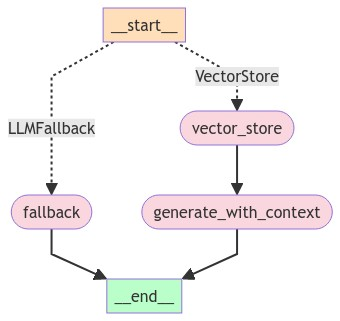

## Loading Data

In [53]:
urls = [
    "https://www.webmd.com/a-to-z-guides/malaria",
    "https://www.webmd.com/diabetes/type-1-diabetes",
    "https://www.webmd.com/diabetes/type-2-diabetes",
    "https://www.webmd.com/migraines-headaches/migraines-headaches-migraines",
]

loader = WebBaseLoader(urls, bs_get_text_kwargs={"strip": True})
docs = loader.load()

## Chunking, Vector Store and Retriever

In [54]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=30)
chunks = text_splitter.split_documents(docs)

embedding_function = HuggingFaceEmbeddings(show_progress=True, multi_process=True)
vector_store = FAISS.from_documents(documents=chunks, embedding=embedding_function)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [55]:
retriever.get_relevant_documents('Symptoms of migraine')

[Document(page_content='This pain may:Begin as a dull ache and then become throbbingGet worse duringphysical activityAffect one sideof your head or move from one side to the other, be in the front of your head, or affect your entire headDuring the headache, you may also:Have nausea (About 80% of people with migraine do, and about half vomit.)Be paleand clammyFeelfaintor dizzyHave neck pain or stiffnessFeel anxious or depressedHave a runny nose or feel stuffed upBe sensitive to light(Noise or odors might also bother', metadata={'source': 'https://www.webmd.com/migraines-headaches/migraines-headaches-migraines', 'title': 'Migraine: Symptoms, Causes, and Treatment', 'description': 'Migraine headaches, also known as migraines, are a type of headache that can cause debilitating pain. Learn more about the types, causes, symptoms, diagnosis, & treatment of migraines.', 'language': 'en'}),
 Document(page_content="around.You feel it mostly on one side of your head.You also have at least one of 

## Chains

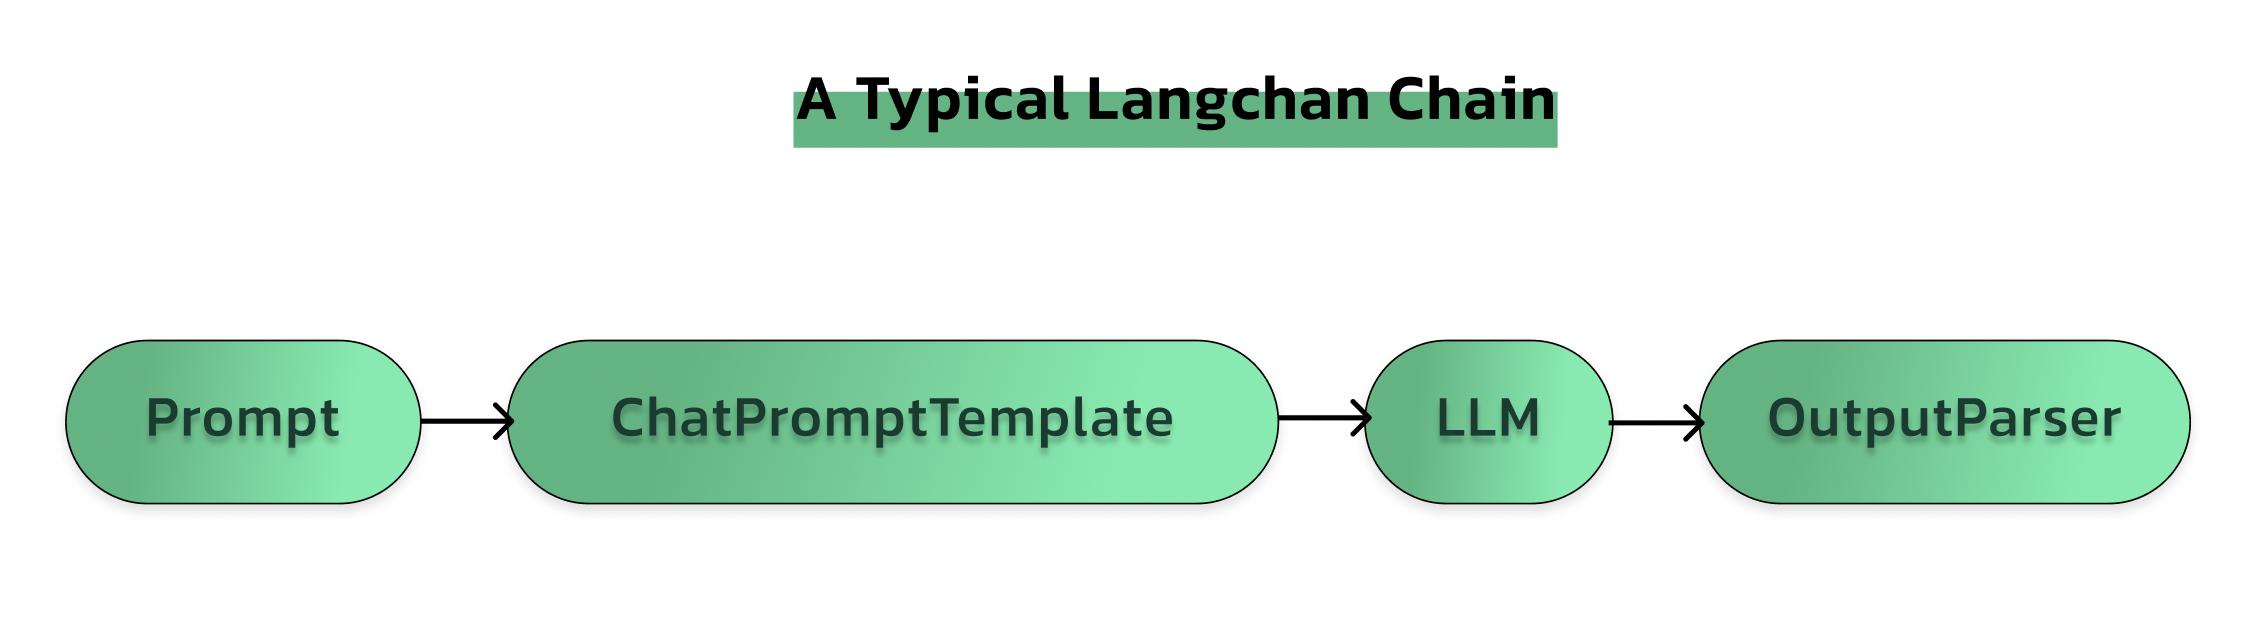

### Prompt

In [56]:

llm = ChatTogether(
    # together_api_key="YOUR_API_KEY",
    model="meta-llama/Llama-3-70b-chat-hf",
    temperature= 0
    )


In [57]:
from pprint import pprint

raw_prompt = "Hi, I'm learning langchain to use it with LLMs and make awesome stuff!"
llm.invoke(raw_prompt).content

"That's awesome! Langchain is a powerful tool for building applications with large language models (LLMs). It provides a simple and flexible way to interact with LLMs, making it easier to build a wide range of language-based applications.\n\nWhat kind of projects are you planning to build with Langchain and LLMs? Are you interested in natural language processing, text generation, conversational AI, or something else?\n\nAlso, what's your experience level with Langchain and LLMs so far? Are you just getting started, or do you have some experience with other NLP libraries or frameworks? I'm here to help you with any questions or challenges you might have!"

In [58]:
prompt_template = "Hi, I'm learning {tool} to use it with LLMs and make awesome stuff!"

prompt_chat_template = ChatPromptTemplate.from_template(
    template=prompt_template,
)

prompt_chat_template.invoke({
    "tool":"llama_index"
})


ChatPromptValue(messages=[HumanMessage(content="Hi, I'm learning llama_index to use it with LLMs and make awesome stuff!")])

In [59]:
prompt = prompt_chat_template.invoke({
    "tool":"llama_index"
})
llm.invoke(prompt).content

"That's great to hear! LlamaIndex is an amazing tool for building applications with Large Language Models (LLMs). It provides a simple and efficient way to index and query large language models, making it easier to integrate them into your projects.\n\nWhat kind of awesome stuff are you planning to build with LlamaIndex and LLMs? Are you looking to create a chatbot, a language-based game, or something entirely new?\n\nIf you have any questions or need help getting started with LlamaIndex, feel free to ask! I'm here to assist you."

In [60]:
chain = prompt_chat_template | llm

chain.invoke(
    {
    "tool":"llama_index"
  }
).content

"That's great to hear! LlamaIndex is an amazing tool for building applications with Large Language Models (LLMs). It provides a simple and efficient way to index and query large language models, making it easier to integrate them into your projects.\n\nWhat kind of awesome stuff are you planning to build with LlamaIndex and LLMs? Are you looking to create a chatbot, a language-based game, or something entirely new?\n\nIf you have any questions or need help getting started with LlamaIndex, feel free to ask. I'm here to assist you!"

In [61]:
# Set up a parser + inject instructions into the prompt template.

router_prompt_template = (
 "You are an expert in routing user queries to either a VectorStore or A Fallback Message\n"
 "Your VectorStore contains data about migraine, diabetes and malaria. if the given query is about one of these diseases, choose VectorStore"
 "If the query is not related to medical questions at all, DO NOT choose any tool."
 "Give me only and only the name of the tool you chose and nothing more. If there are no chose tool, give me back the string None"
 "{output_instructions}"
 "query: {query}"
)


prompt = ChatPromptTemplate.from_template(
    template=router_prompt_template,
)


### Pydantic Parser

In [62]:
from typing import Literal



class ChosenTool(BaseModel):
    tool_name: Literal['None', "VectorStore"] = Field(description="the tool that was chosen by LLM in question routing stage")


question_router_parser = PydanticOutputParser(pydantic_object=ChosenTool)

question_router_parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"tool_name": {"title": "Tool Name", "description": "the tool that was chosen by LLM in question routing stage", "enum": ["None", "VectorStore"], "type": "string"}}, "required": ["tool_name"]}\n```'

In [63]:
question_router = prompt | llm | question_router_parser

res = question_router.invoke({"query": "my name is vahid",
                                   "output_instructions": question_router_parser.get_format_instructions()
 })
res

ChosenTool(tool_name='None')

In [64]:
test_chain = prompt | llm

test_chain.invoke({
    "query": "how dangerous is migraines?",
    "output_instructions": question_router_parser.get_format_instructions()
})

AIMessage(content='{"tool_name": "VectorStore"}', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 283, 'total_tokens': 292}, 'model_name': 'meta-llama/Llama-3-70b-chat-hf', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-ae57ec5f-28e8-46b9-88c3-608ced1bee8f-0', usage_metadata={'input_tokens': 283, 'output_tokens': 9, 'total_tokens': 292})

### Generate with Context Chain

In [65]:
generate_with_context_template = (
    "You are a helpful assistant. Answer the query below based only on the provided context. If the given context is not relevant, DO NOT answer based on your own knowledge\n\n"
    "context: {context}\n\n"
    "query: {query}"
)


generate_with_context_prompt = ChatPromptTemplate.from_template(generate_with_context_template)
generate_with_context_chain = generate_with_context_prompt | llm | StrOutputParser()

query = "What are the symptoms of malaria?"
context = retriever.get_relevant_documents(query)
# context = "my name is vahid :)"
response = generate_with_context_chain.invoke({"query": query, "context": context})

Markdown(response)

Based on the provided context, the symptoms of malaria include:

* Impaired consciousness
* Convulsions
* Difficulty breathing
* Serious tiredness and fatigue
* Dark or bloody urine
* Yellow eyes and skin (jaundice)
* Abnormal bleeding
* Very tired (fatigue)
* Body aches
* Yellow skin (jaundice)
* Kidney failure
* Seizure
* Confusion
* Bloody stools
* Convulsions
* Death
* High fever
* Chills
* Sweating
* Nausea or vomiting
* Headache
* Diarrhea

Note that some of these symptoms may be similar to those of a cold or flu, and it may be difficult to tell what you have at first.

In [66]:
fallback_prompt = ChatPromptTemplate.from_template(
    (
        "You are a friendly medical assistant created by NLP Staff Course in University of Tehran.\n"
        "Do not respond to queries that are not related to health.\n"
        "If a query is not related to health, acknowledge your limitations.\n"
        "Provide concise responses to only medically-related queries.\n\n"
        "Current conversations:\n\n{chat_history}\n\n"
        "human: {query}"
    )
)

fallback_chain = (
    {
        "chat_history": lambda x: "\n".join(
            [
                (
                    f"human: {msg.content}"
                    if isinstance(msg, HumanMessage)
                    else f"AI: {msg.content}"
                )
                for msg in x["chat_history"]
            ]
        ),
        "query": itemgetter("query") ,
    }
    | fallback_prompt
    | llm
    | StrOutputParser()
)

fallback_chain.invoke(
    {
        "query": "Hello",
        "chat_history": [],
    }
)

"Hello! I'm happy to help with any medical-related questions or concerns you may have. What's on your mind today?"

# Agent Workflow

In [67]:
from typing import TypedDict, Annotated
from langchain_core.documents import Document
from langchain_core.messages.base import BaseMessage
import operator




class AgentSate(TypedDict):
    """The dictionary keeps track of the data required by the various nodes in the graph"""

    query: str
    chat_history:list[BaseMessage]
    generation: str
    documents: list[Document]


def retrieve_node(state: dict):
    """
    Retrieve relevent documents from the vectorstore

    query: str

    return list[Document]
    """
    query = state["query"]
    documents = retriever.invoke(input=query)
    return {"documents": documents}


def fallback_node(state: dict):
    """
    Fallback to this node when there is no tool call
    """
    query = state["query"]
    chat_history = state["chat_history"]
    generation = fallback_chain.invoke({"query": query, "chat_history": chat_history})
    return {"generation": generation}



def generate_with_context_node(state: dict):
    query = state["query"]
    documents = state["documents"]

    generation = generate_with_context_chain.invoke({"query": query, "context": documents})
    return {"generation": generation}



def question_router_node(state: dict):
    query = state["query"]
    try:
        response = question_router.invoke({"query": query,
                                   "output_instructions": question_router_parser.get_format_instructions()
        })
        print(response)
    except Exception:
        print("Exception in getting response")
        return "LLMFallback"
    try:
      chosen_tool = response.tool_name.lower()
    except Exception:
        return "LLMFallback"

    if chosen_tool == 'none':
        print("---No tool called---")
        return "LLMFallback"


    if chosen_tool == "vectorstore":
        print("---Routing to VectorStore---")
        return "VectorStore"

In [68]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentSate)

workflow.add_node("vector_store", retrieve_node)
workflow.add_node("fallback", fallback_node)
workflow.add_node("generate_with_context", generate_with_context_node)

workflow.set_conditional_entry_point(
    question_router_node,
    {
        "LLMFallback": "fallback",
        "VectorStore": "vector_store",
    },
)

workflow.add_edge("vector_store", "generate_with_context")

workflow.add_edge("generate_with_context", END)

workflow.add_edge("fallback", END)


In [69]:
app = workflow.compile(debug=False)
plot = app.get_graph().draw_mermaid_png()

with open("plot.png", "wb") as fp:
    fp.write(plot)

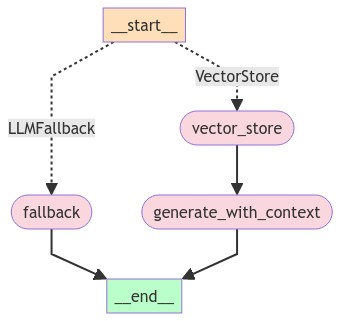

In [70]:
from io import BytesIO
from PIL import Image
from IPython.display import display

img = Image.open(BytesIO(plot))
display(img)

In [71]:
response = app.invoke({"query": "who is the president of Iran?", "chat_history": []})
Markdown(response["generation"])

tool_name='None'
---No tool called---


I'm happy to help! However, I'm a medical assistant, and my expertise lies in providing information related to health and medicine. I'm not equipped to answer questions about politics or government officials. If you have any health-related questions, I'd be more than happy to assist you!

In [72]:
import gradio as gr
from uuid import uuid4

history = {}
session_id = str(uuid4())

def chat(query):

    # Initialize the chat history for the current session
    if session_id not in history:
        history[session_id] = []

    chat_history = history[session_id]

    # Invoke the app with the current query and chat history
    result = app.invoke({"query": query, "chat_history": chat_history})

    # Separate the response from the retrieved documents
    response = result["generation"]
    documents = result["documents"]

    # Add the current exchange to the chat history
    chat_history.extend([HumanMessage(content=query), AIMessage(content=response)])

    if not documents:
        return response, documents

    documents = [
        f"{doc.page_content}\nsource: {doc.metadata['source']}" for doc in documents
    ]

    return response, "\n\n".join(documents)

# Create the Gradio interface
demo = gr.Interface(
    fn=chat,
    inputs=gr.Textbox(label="Question"),
    outputs=[gr.Textbox(label="Response"), gr.Textbox(label="Retrieved Documents")],
    title="RAG Chatbot",
    description="Ask a health-related query and the chatbot will generate a response using Retrieval Augmented Generation.",
)

if __name__ == "__main__":
    demo.launch(share=True, inline=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://aaaed73fe591c8166d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
